# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

To run the code in the cell, set try_random_actions to True. Once this cell is executed, you will watch the agents' performance, as they select actiona at random at each time step. A window should pop up that allows you to observe the agents, as they move through the environment.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
try_random_actions = False

if try_random_actions:
    for i in range(1, 6):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment as shown below. Note however that once the environment is closed, you need to restart the notebook to be able to continue running the remaining cells. Once you restart the notebook, change try_random_actions in the above cell to False to skip running that cell and the subsequent one that closes the environment.

In [6]:
if try_random_actions:
    env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### 5. Import the Necessary Packages


In [7]:
import torch
import random
import time
import pprint
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent, override_config

### 6. Instantiate the Environment and a Multi-Agent DDPG

In [8]:
config = {"state_size": state_size,
          "action_size": action_size,
          "parallel_agents": num_agents,
                    
          # Actor and Critic model parameters
          "actor_layer_sizes": [256, 128],
          "critic_layer_sizes": [256, 128],
          
          # Agent's parameters
          "train_every": 20,
          "train_steps": 10,
          "buffer_size": int(1048576) , # power of two
          "batch_size": 512,
          "lr_actor": 1e-4,
          "lr_critic": 1e-3,
          "weight_decay": 0.00001,
          "gamma": 0.99,
          "tau": 0.001, 
          "tau_increase": 1.0001, # definitely use 1.0001 for prioritized replay. Otherwise, 1.001
          
          # Exploration using noise or random actions
          "add_noise": True,           # If I turn this off, it looks like the agent learns overfits and plays a fixed game!
          "use_ounoise": True,
          "random_action_period": 2000, # If I turn off both sources of noise, the agent still learns (but without prioritized replay), but more slowly. Perhpas the replay buffer is the source of noise.
          "minimum_random_action_prob": 0.01, # If I turn off both noise, the prioritized replay buffer better be off!

          # OUNoise parameters
          "noise_theta": 0.15,
          "noise_sigma": 0.2,
          "theta_decay": 0.99,
          "sigma_decay": 0.99,
          
          # Prioritized replay parameters
          "prioritized_replay": False,
          "epsilon_error": 1e-7,
          "maximum_error": 1e4,
          "alpha": 0.6,
          "beta_start": 0.4,
          "beta_decay": 0.99,
          "beta_end": 1.0
         }

# Override the global parameters used by the agent
override_config(config)

agent = Agent(state_size=state_size, action_size=action_size, random_seed=2,
              prioritized_replay=config["prioritized_replay"], use_ounoise=config["use_ounoise"],
              parallel_agents=num_agents, train_every=config["train_every"], train_steps=config["train_steps"])

### 7. Train the DDPG Agent

{'action_size': 2,
 'actor_layer_sizes': [256, 128],
 'add_noise': True,
 'alpha': 0.6,
 'batch_size': 512,
 'beta_decay': 0.99,
 'beta_end': 1.0,
 'beta_start': 0.4,
 'buffer_size': 1048576,
 'critic_layer_sizes': [256, 128],
 'epsilon_error': 1e-07,
 'gamma': 0.99,
 'lr_actor': 0.0001,
 'lr_critic': 0.001,
 'maximum_error': 10000.0,
 'minimum_random_action_prob': 0.01,
 'noise_sigma': 0.2,
 'noise_theta': 0.15,
 'parallel_agents': 2,
 'prioritized_replay': False,
 'random_action_period': 2000,
 'sigma_decay': 0.99,
 'state_size': 24,
 'tau': 0.001,
 'tau_increase': 1.0001,
 'theta_decay': 0.99,
 'train_every': 20,
 'train_steps': 10,
 'use_ounoise': True,
 'weight_decay': 1e-05}
Episode 100	Runtime 19.33	Average Score: 0.01
Episode 200	Runtime 21.62	Average Score: 0.00
Episode 300	Runtime 22.21	Average Score: 0.00
Episode 400	Runtime 20.46	Average Score: 0.00
Episode 500	Runtime 22.22	Average Score: 0.00
Episode 600	Runtime 22.06	Average Score: 0.00
Episode 700	Runtime 23.93	Average 

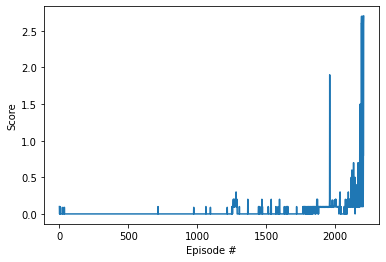

In [9]:
train_every = config["train_every"]  # train the agent after every train_every time steps
train_steps = config["train_steps"]  # train for train_steps after every train_every time steps

add_noise = config["add_noise"]      
noise_theta = config["noise_theta"]  # OUNoise theta
noise_sigma = config["noise_sigma"]  # OUNoise sigma
theta_decay = config["theta_decay"]  # 0.99
sigma_decay = config["sigma_decay"]  # 0.99

gamma = config["gamma"]

beta_start = config["beta_start"]
beta_decay = config["beta_decay"]
beta_end = config["beta_end"]    

# Increase tau
# Add noisy actions that reduce in frequency during the first 1500 steps but never go to zero
# When training the actor through the critic, and passing state and action to the critic, compute the
# value of the situation assuming that only your action has changed (what the actor computes), but that
# the other agent's actions have not changed

def ddpg(n_episodes=10000, print_every=100, solution_score=0.5, train=True):
    scores_deque = deque(maxlen=print_every)
    scores_array = []
    theta = noise_theta
    sigma = noise_sigma
    store_only_steps_remaining = train_every
    train_steps_remaining = 0
    trained_steps = 0
    steps = 0
    trained_steps = 0
    beta = beta_start
    
    start_time = time.time()
    print_every_start_time = start_time

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train)[brain_name]     # reset the environment VIDA: What's train_mode?   
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset(theta, sigma)
        theta *= theta_decay
        sigma *= sigma_decay
        while True:
            actions = agent.act(states, add_noise=add_noise)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            rewards = env_info.rewards                         # get reward (for each agent)
            scores += rewards                                  # update the score (for each agent)
        
            agent.step(states, actions, rewards, next_states, dones, beta=beta)
                            
            states = next_states
            if np.any(dones):                                  # exit loop if episode finished
                break 

        scores_deque.append(np.max(scores))
        scores_array.append(np.max(scores))
        average_over_window = np.mean(scores_deque)
        
        end_time = time.time()
        runtime = end_time - start_time
        start_time = end_time
        print('\rEpisode {}\tRuntime {:.2f}\tAverage Score: {:.2f}'.format(i_episode, runtime, average_over_window), end="")
        
        if train and config["prioritized_replay"] and i_episode >= 100:
            beta = min(beta_end, (1 - beta_decay * (1 - beta)))
        
        if i_episode % print_every == 0:
            print_every_end_time = time.time()
            runtime = print_every_end_time - print_every_start_time
            print_every_start_time = print_every_end_time
            print('\rEpisode {}\tRuntime {:.2f}\tAverage Score: {:.2f}'.format(i_episode, runtime, average_over_window))
        
        if len(scores_deque) >= print_every:            
            if average_over_window >= solution_score:
                print('\rSolved after Episode {}\tAverage Score: {:.2f}'.format(i_episode, average_over_window))
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                break
            
    return scores_array

pprint.pprint(config)
scores = ddpg(train=True)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 8. Load the Trained Agent

In [10]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

### 9. Watch the Trained Agent in Action

Run the next cell to watch the trained agent's performance. A window should pop up that allows you to observe the agent(s) acting in the environment.

In [11]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states, add_noise=False)       # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 1.3000000193715096
Score (max over agents) from episode 3: 2.600000038743019
Score (max over agents) from episode 4: 2.7000000402331352
Score (max over agents) from episode 5: 2.600000038743019


When finished, you can close the environment by uncommenting the following line and running the cell.

In [12]:
# env.close()